# Introduction

The applications of brain tumour classification can be mainly divided into two categories:
- Classification of brain images into normal and abnormal classes, i.e. whether the brain images contain tumours or not.
- Classification within abnormal brain images, in other words, discrimination between different types of brain tumours.

We are in the first case here, which is a binary classification (normal and abnormal). The important of this study is also contain by the fact of conventional diagnoses of brain tumor images are made by human interpretation, which heavily relies on the experience of radiologists who review and analyze the characteristics of the images. Consequently, interobserver and intraobserver variability are inevitable. That's why computer-aided diagnosis system can be very interesting to reduce the number of errors and help the diagnostic decision.

This brain tumor dataset containing 253 images with two possibilities: normal MRI (no tumor), or abnormal MRI (tumor). The original data can be found following this link: [kaggle-brain-mri-images](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection).

The objective of this project is to build a classifier to classify each type of tumor.

In [39]:
# Imports
import random
import zipfile
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16

In [46]:
# Constants
DATA_PATH = "./data/kaggle/"

IMAGE_SHAPE = (256, 256)

LABELS_NAME = {
    0 : "No tumor",
    1 : "Tumor"
}

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 512

SPLIT_SIZE = 0.7

EPOCHS = 15

In [3]:
def show_image(images: np.ndarray, labels: np.ndarray, names: dict=LABELS_NAME) -> None:
    """Take the a random image and plot it, with as title the class label of the image.

    Args:
        images (ndarray):
        labels (ndarray):
        border (list):
        names (dict):
            Defaults to LABELS_NAME.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()

def predict_image(images: np.ndarray, labels: np.ndarray, prediction: np.ndarray) -> None:
    """Take the a random image and plot it, with as title the predicted value
    of the image.

    Args:
        images (ndarray):
        labels (ndarray):
        prediction (ndarray):
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx],  cmap='gray')
    plt.title(f"True class: {labels[idx]} \n Predicted class: {prediction[idx]}")
    plt.axis('off')
    plt.show()

@tf.function
def map_image(image: np.ndarray, label: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Cast image type to float32 and normalize it. Note that the function is decorated to enable
    graph mode in Tensorflow.

    Args:
        image (ndarray): The array of images.
        label (ndarray): The array of labels

    Returns:
        ndarray: The array of images casted and normalized.
        ndarray: The unchanged array of labels.
    """
    image = tf.cast(image, dtype=tf.float16)
    image = image / 255.0
    image = tf.image.grayscale_to_rgb(image)

    return image, label

def train_one_step(
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Adam,
    x: tf.Tensor,
    y: tf.Tensor,
    train_loss: tf.keras.losses.SparseCategoricalCrossentropy,
    train_accuracy: tf.keras.metrics.SparseCategoricalAccuracy
) -> tf.keras.losses.SparseCategoricalCrossentropy:
    """Trains on a batch of images for one step.

    Args:
        model (Model): CNN classifier.
        optimizer (Adam): optimizer to use during training.
        x (Tensor): training images.
        y (Tensor): training labels.
        train_loss (keras Loss): loss object for training.
        train_accuracy (keras Metric): accuracy metric for training.

    Returns:
        SparseCategoricalCrossentropy : loss object calculated during training.
    """
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss
        loss = train_loss(y_true=y, y_pred=predictions)

    # Compute the gradients on model variables
    grads = tape.gradient(loss, model.trainable_weights)

    # Apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)

    return loss

# Decorate this function to enable autograph on the training loop
@tf.function
def train(
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Adam,
    epochs: int,
    device: str,
    train_ds: tf.data.Dataset,
    train_loss: tf.keras.losses.BinaryCrossentropy,
    train_accuracy: tf.keras.metrics.BinaryAccuracy,
    valid_ds: tf.data.Dataset,
    val_loss: tf.keras.losses.BinaryCrossentropy,
    val_accuracy: tf.keras.metrics.BinaryAccuracy
):
    """Performs the entire training loop. Prints the loss and accuracy per step and epoch. Note
    that the function is decorated to enable graph mode in Tensorflow.

    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    """
    loss = 0.0

    for epoch in range(epochs):
        for x, y in train_ds:
            # Training step number increments at each iteration
            with tf.device(device_name=device):
                # Run one training step
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)

        # Print the training step number, loss and accuracy
        tf.print('EPOCH:', epoch)
        tf.print('train loss:', loss, '- train accuracy:', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)

        # Print the validation loss and accuracy
        tf.print('val loss:', loss, '- val accuracy:', val_accuracy.result())

## Data loading

In [42]:
# Define lists to store images and labels
image_list, label_list = [[] for _ in range(2)]

# Read the zip file
with zipfile.ZipFile(os.path.join(DATA_PATH, 'BrainTumorData.zip'), 'r') as zip_ref:
    # Get the list of files
    files = zip_ref.namelist()

    for file in files:
        # Load the image
        with zip_ref.open(file) as bytes:
            image_list.append(tf.keras.preprocessing.image.load_img(
                BytesIO(bytes.read()),
                color_mode='grayscale',
                target_size=IMAGE_SHAPE
            ))
        # Get the label
        label_list.append(int(file.split('/')[0] == "yes"))

assert len(image_list) == len(label_list)

In [43]:
# Concatenate the list of images into a single numpy array
images = np.expand_dims(np.stack(image_list), axis=3)
# Convert the labels list to a numpy array
labels = np.array(label_list).reshape(-1)

print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: (253, 256, 256, 1)
Label shape: (253,)


## Exploratory Data Analysis

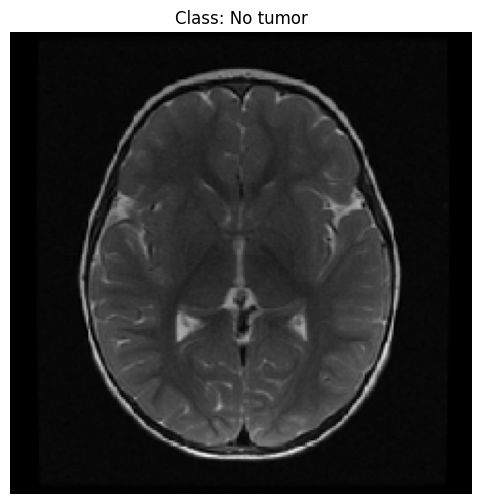

In [8]:
# Plot an image
show_image(images, labels)

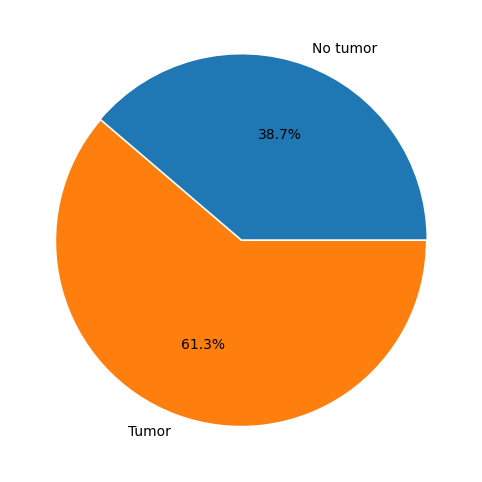

In [9]:
# Repartition of the classes across the dataset
_, counts = np.unique(labels, return_counts=True)

# Plot classes counts
plt.figure(figsize=(9, 6))
plt.pie(
    counts,
    labels=["No tumor", "Tumor"],
    autopct="%1.1f%%",
    explode=(0.01, 0)
)
plt.show()

## Preprocessing

In [44]:
# Split train data
X_train, X_tmp, y_train, y_tmp = train_test_split(
    images,
    labels,
    shuffle=True,
    stratify=labels,
    train_size=SPLIT_SIZE,
    random_state=42
)

# Split validation and test data
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    shuffle=True,
    stratify=y_tmp,
    train_size=SPLIT_SIZE,
    random_state=42
)

In [45]:
# Load the datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(map_image).shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE).prefetch(1)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(map_image).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(map_image).batch(BATCH_SIZE)

## Modeling

In [51]:
# Load ResNet50 model
pre_trained_model = VGG16(
    input_shape=IMAGE_SHAPE + (3, ),
    include_top=False
)

# Freez ResNet50 layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [52]:
# Model definition
last_output = pre_trained_model.output

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(last_output)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=pre_trained_model.input, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [48]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam()
# Define losses
train_loss = tf.keras.losses.BinaryCrossentropy()
val_loss = tf.keras.losses.BinaryCrossentropy()
# Define metrics
train_accuracy = tf.keras.metrics.BinaryAccuracy()
val_accuracy = tf.keras.metrics.BinaryAccuracy()

In [49]:
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
print(device)

/gpu:0


In [53]:
train(
    model,
    optimizer,
    EPOCHS,
    device,
    train_ds,
    train_loss,
    train_accuracy,
    val_ds,
    val_loss,
    val_accuracy
)

EPOCH: 0
train loss: 0.617171943 - train accuracy: 0.531073451
val loss: 0.638226688 - val accuracy: 0.622641504
EPOCH: 1
train loss: 0.587530077 - train accuracy: 0.573446333
val loss: 0.573068082 - val accuracy: 0.669811308
EPOCH: 2
train loss: 0.560640812 - train accuracy: 0.632768333
val loss: 0.465382636 - val accuracy: 0.679245293
EPOCH: 3
train loss: 0.339016676 - train accuracy: 0.690677941
val loss: 0.349237084 - val accuracy: 0.71226418
EPOCH: 4
train loss: 0.362392813 - train accuracy: 0.727683604
val loss: 0.266065598 - val accuracy: 0.739622653
EPOCH: 5
train loss: 0.219623283 - train accuracy: 0.754237294
val loss: 0.251664579 - val accuracy: 0.751572311
EPOCH: 6
train loss: 0.520711422 - train accuracy: 0.778046787
val loss: 0.405309737 - val accuracy: 0.762803257
EPOCH: 7
train loss: 0.112564802 - train accuracy: 0.792372882
val loss: 0.348401487 - val accuracy: 0.76886791
EPOCH: 8
train loss: 0.235782117 - train accuracy: 0.806654096
val loss: 0.302369356 - val accurac

In [54]:
# Make predictions
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model.predict(images)
        preds = np.where(preds > .5, 1, 0).reshape(-1)

1/1 [==============================] - 3s 3s/step


In [55]:
accuracy_score(y_test, preds)

0.8695652173913043

In [56]:
confusion_matrix(y_test, preds)

array([[ 7,  2],
       [ 1, 13]])

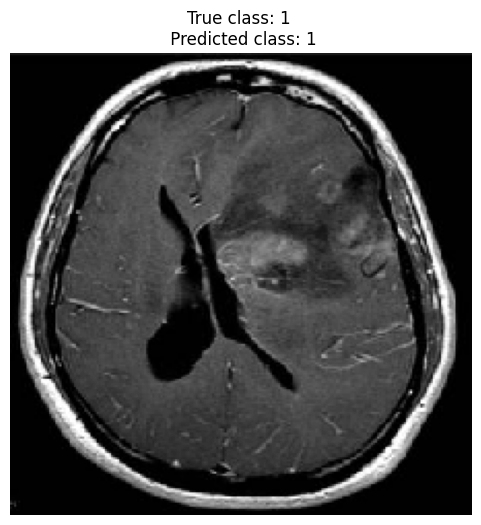

In [34]:
predict_image(X_test, y_test, preds)